<a href="https://colab.research.google.com/github/ekingit/DeepForecast/blob/main/3_hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import torch
import matplotlib.pyplot as plt
from google.colab import drive
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
drive.mount('/content/gdrive')
!cp /content/gdrive/MyDrive/Colab\ Notebooks/weather_forecast/Data/data.py /content/data.py
!cp /content/gdrive/MyDrive/Colab\ Notebooks/weather_forecast/models.py /content/models.py
!cp /content/gdrive/MyDrive/Colab\ Notebooks/weather_forecast/train.py /content/train.py
from data import Sine_Data, Weather_Data
from models import RNN_periodic, local_LSTM, LSTM_periodic
from train import train_lstm, test_lstm

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#import data
nat_data = Weather_Data('/content/gdrive/MyDrive/Colab Notebooks/weather_forecast/Data/weather_prediction_dataset.csv','BASEL_temp_max')
synt_data = Sine_Data(2/365.25,3654,3/2)
X_sine = synt_data.x.unsqueeze(-1)
X_raw = nat_data.tens # all weather data - no train-test split

In [ ]:
#import global model
path = '/content/gdrive/MyDrive/Colab Notebooks/weather_forecast/Results/periodic/model2.pth'
RNN_model = RNN_periodic(1,10,3)
RNN_model.load_state_dict(torch.load(path, weights_only=True))
RNN_model.eval()

RNN_periodic(
  (rnn): RNN(1, 10, num_layers=3)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)

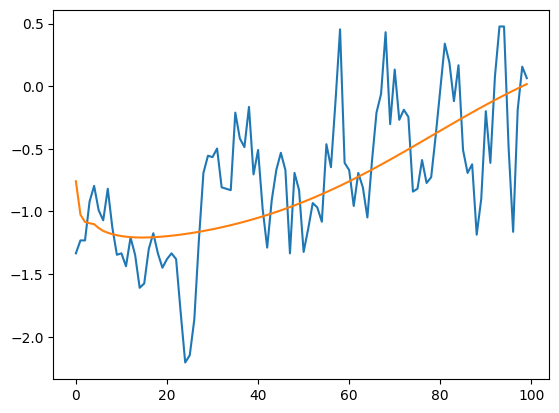

In [ ]:
H = torch.zeros(3,10)
periodic_data, _ = RNN_model(X_sine,H)
periodic_data = periodic_data.detach()
plt.plot(X_raw[:100])
plt.plot(periodic_data.detach()[:100])


In [ ]:
def data_chunks(X, N, k): #N=seq_len, k=target size (k-step predictions)
    in_train = [X[i:i+N] for i in range(len(X)-N-k+1)]
    in_train = torch.stack(in_train,0)
    out_train = [X[i+N:i+N+k] for i in range(len(X)-N-k+1)]
    out_train = torch.stack(out_train,0)
    return in_train, out_train

# Train Local Model

In [ ]:
# Calculate noise: raw_data - periodic_data
noise = X_raw - periodic_data
#data split train-validation-test
days_of_years = [0]+[sum(366 if i % 4 == 0 else 365 for i in range(year+1)) for year in range(0,10)]
split_year = 8
noise_train = noise[0:days_of_years[split_year]]
noise_val = noise[days_of_years[split_year]:days_of_years[split_year+1]]
noise_test = noise[days_of_years[split_year+1]:]
#apply data chunks: in_data.shape=(N,14,1), out_data=(N,7)
seq_len = 14
target_seq_len = 7
noise_train_in, noise_train_out = data_chunks(noise_train, seq_len, target_seq_len)
noise_val_in, noise_val_out = data_chunks(noise_val, seq_len, target_seq_len)
noise_test_in, noise_test_out = data_chunks(noise_test,seq_len,target_seq_len)
#DataLoaders for batching
ds_noise_train = TensorDataset(noise_train_in, noise_train_out)
ds_noise_val = TensorDataset(noise_val_in, noise_val_out)
ds_noise_test = TensorDataset(noise_test_in, noise_test_out)

dl_noise_train = DataLoader(ds_noise_train, batch_size=128, shuffle=False)
dl_noise_val = DataLoader(ds_noise_val, batch_size=128, shuffle=False)
dl_noise_test = DataLoader(ds_noise_test, batch_size=128, shuffle=False)

In [ ]:
ind = 0
hidden_size = 20
num_layers = 3
lr = 1e-4
num_epoch = 1500
save_model_path =f'/content/gdrive/MyDrive/Colab Notebooks/weather_forecast/Results/model_hybrid0.pth'
batch_size = 128
model_name = 'local_LSTM'
device = 'cuda'

In [ ]:
#model
model = local_LSTM(1,hidden_size,num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
mse_loss = nn.MSELoss(reduction='sum')
#RUN!
train_loss_list = []
val_loss_list = []
best_loss = 0.5
a=time.time()
for epoch in range(num_epoch):
    train_loss = train_lstm(model, dl_noise_train, optimizer, mse_loss, hidden_size, num_layers, device=device)
    val_loss = test_lstm(model, dl_noise_val, mse_loss, hidden_size, num_layers, device=device)
    if val_loss < best_loss:
        best_loss = val_loss
        best_epoch = epoch
        best_train = train_loss
        test_loss = test_lstm(model, dl_noise_test, mse_loss, hidden_size, num_layers, device=device)
        torch.save(model.state_dict(), save_model_path)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    if epoch %100 == 0:
            print(f"epoch: {epoch} train loss: {train_loss}, validation loss: {val_loss}")
b=time.time()

epoch: 0 train loss: 0.29585344908544253, validation loss: 0.2292175702473824
epoch: 100 train loss: 0.23999759298123466, validation loss: 0.20478592422951558
epoch: 200 train loss: 0.23242599053142038, validation loss: 0.1993414881207744
epoch: 300 train loss: 0.22981725814622536, validation loss: 0.19763179183695356
epoch: 400 train loss: 0.2281310714416714, validation loss: 0.19644513433379246
epoch: 500 train loss: 0.2270287148206267, validation loss: 0.19563349527725987
epoch: 600 train loss: 0.22633743924607297, validation loss: 0.19514877042132503
epoch: 700 train loss: 0.22589273538201698, validation loss: 0.19486372023943926
epoch: 800 train loss: 0.22560187156972447, validation loss: 0.19470893362157116
epoch: 900 train loss: 0.22540977074661697, validation loss: 0.19464326160786863
epoch: 1000 train loss: 0.2252769755650496, validation loss: 0.19463361618835803
epoch: 1100 train loss: 0.22517683121753604, validation loss: 0.19465671227452777
epoch: 1200 train loss: 0.2250937

In [ ]:
best_loss, best_epoch, best_train, test_loss

(0.19463221127095054, 971, 0.22531118390127536, 0.18587624308100226)

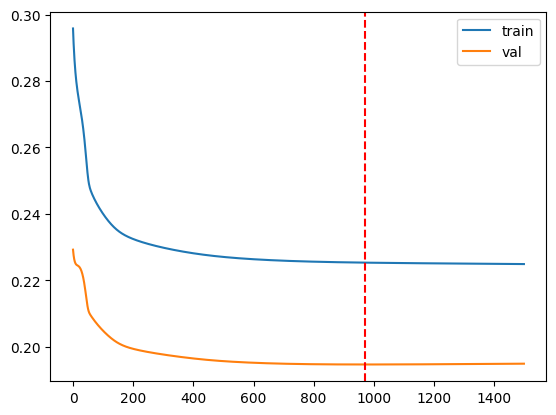

In [ ]:
save_plot_path = f'/content/gdrive/MyDrive/Colab Notebooks/weather_forecast/Results/plt{ind}.png'
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.legend(['train','val'])
plt.axvline(x=best_epoch, color='r', linestyle='--')
plt.savefig(save_plot_path)